## ADA 442 PROJECT

*   Yiğit Özarslan
*   Batuhan İşcan

This project aims to predict whether a client of a Portuguese banking institution will subscribe to a term deposit based on data from direct marketing campaigns. The dataset used is the Bank Marketing Data Set, specifically the "bank-additional.csv" file, which contains 4119 examples with 20 input features.

The classification goal is to determine if a client will subscribe to a term deposit ('yes') or not ('no'). To achieve this, various encoding techniques such as Ordinal Encoding, Label Encoding, and One-Hot Encoding were applied to preprocess the categorical data before building the machine learning models.

The following sections of this notebook will walk through the data preprocessing steps, model training, and evaluation processes used to predict the subscription status of the clients.

## Import modules

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
%matplotlib inline

## Loading the dataset

We load the dataset and create two copies for further processing, then check unique values in the nr.employed column, obtain a statistical summary using describe(), and review data types and null values with info().

In [3]:
df = pd.read_csv('./bank-additional.csv', delimiter=';')
dfs = df.copy()
dfl = df.copy()

In [97]:
df['nr.employed'].unique()

array([5099.1, 5191. , 5228.1, 5195.8, 4963.6, 5008.7, 5076.2, 4991.6,
       5017.5, 5023.5, 5176.3])

In [5]:
# statistical info
df.describe()
# datatype info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

## Data Exploration

We visualize the target variable y with a histogram, summarize it, plot the distribution of the job feature and age feature, calculate and display the mean, median, and mode of age, filter out outliers, transform the age feature using logarithm and square root transformations, and update the dataset with the log-transformed age values, followed by displaying the first few rows of the dataset.

count     4119
unique       2
top         no
freq      3668
Name: y, dtype: object

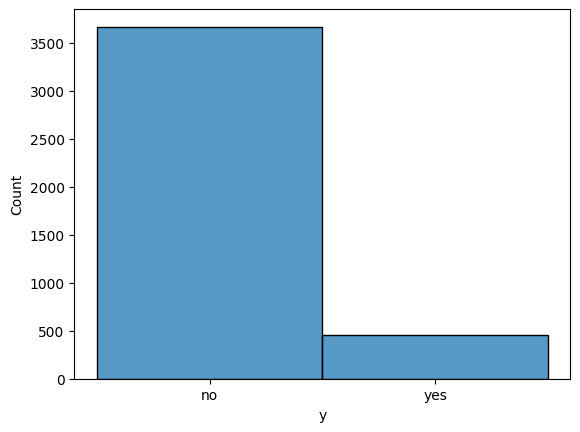

In [6]:
sns.histplot(df['y'])
df['y'].describe()

There is a very skewed response to the term deposit subscription. This might cause issues during sampling.

<Axes: xlabel='count', ylabel='job'>

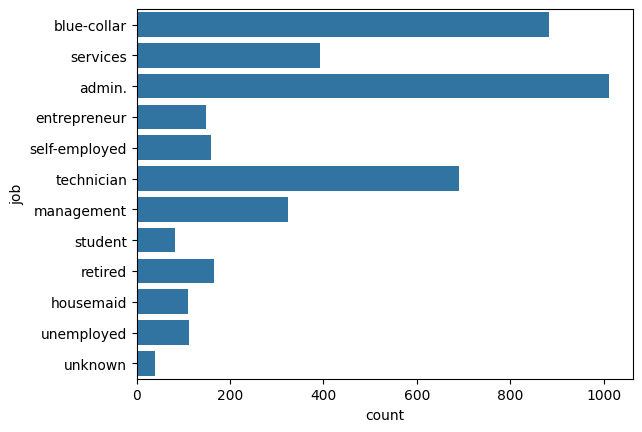

In [7]:
sns.countplot(df['job'])

As can be seen, there are a majority of blue collars or administrators that are in the dataframe.

<Axes: xlabel='age', ylabel='Density'>

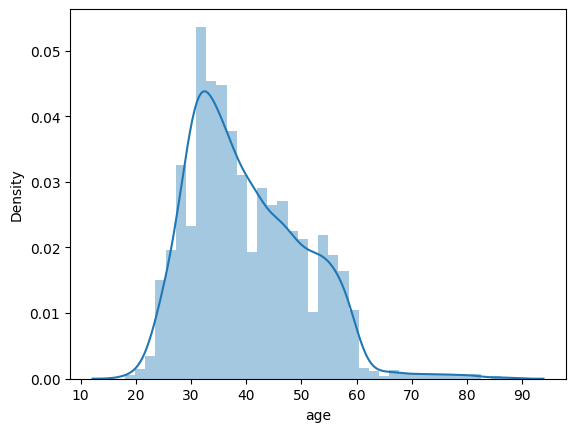

In [8]:
sns.distplot(df['age'])

In [9]:
print(df['age'].mean())
print(df['age'].median())
print(df['age'].mode())

40.11361981063365
38.0
0    32
Name: age, dtype: int64


As we can see, the age is skewed to the right as underaged people are less likely to have term deposits. We can analyze this after dropping some of the outliers.

In [10]:
ages = pd.Series(df['age'])
z_scores = np.abs(stats.zscore(ages))
filtered_ages = ages[(z_scores < 3)]
log_ages = np.log(ages + 1)
sqrt_ages = np.sqrt(ages)

Using different methods to normalize the series.

<Axes: xlabel='age', ylabel='Count'>

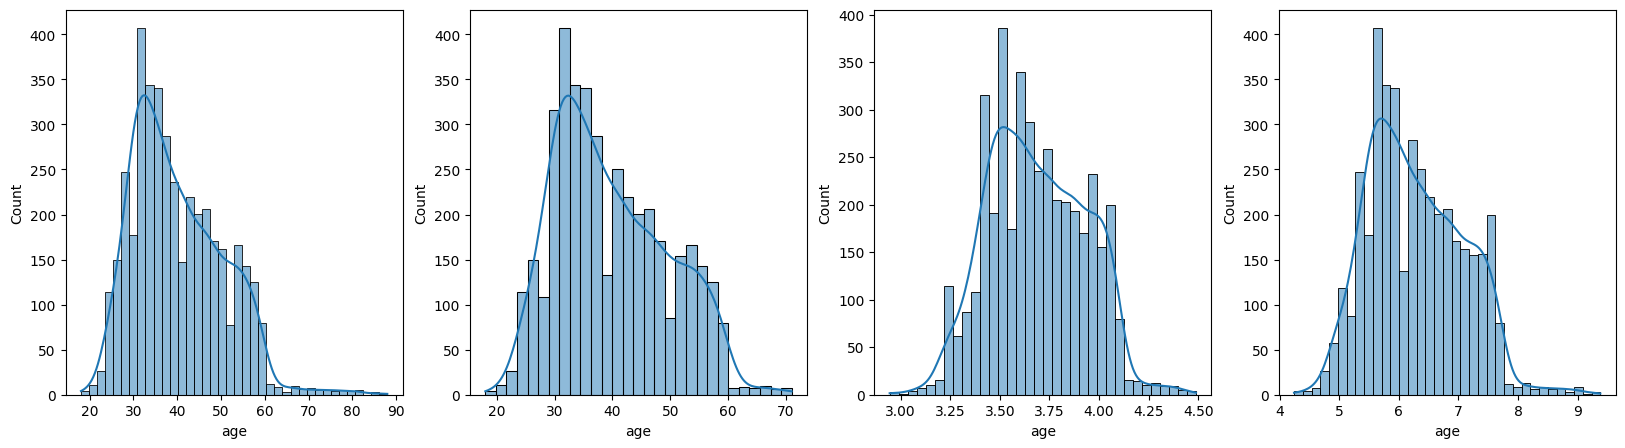

In [11]:
fig, ax = plt.subplots(nrows= 1, ncols= 4, figsize= (20, 5))
sns.histplot(data= ages, ax= ax[0], kde= True)
sns.histplot(data= filtered_ages, ax= ax[1], kde= True)
sns.histplot(data= log_ages, ax= ax[2], kde= True)
sns.histplot(data= sqrt_ages, ax= ax[3], kde= True)

Using these different histograms, we can see that the ages put through the logarithm follow the normal distribution better. This log_ages will replace ages in a copied DataFrame and used to compare with models without this feature.

In [12]:
dfl['age'] = log_ages

In [13]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


## Creating a Pipeline element to specify Preprocessing 

We define the preprocessing elements and and create pipeline elements to later use in the training.

In [14]:
education_categories = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
month_categories = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
day_categories = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]

# Define ordinal encoding for education, month, and day_of_week
ordinal_features = ["education", "month", "day_of_week"]
ordinal_transformer = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder(categories=[education_categories, month_categories, day_categories]))
])

# Define one-hot encoding for the the categorical features
categorical_features = ["job", "marital", "default", "housing", "loan", "contact", "poutcome"]
onehot_transformer = Pipeline(steps=[
    ('onehot_encoder', OneHotEncoder())
])

# Define standard scaling for numerical features
numeric_features = ["age", "duration", "campaign", "pdays", "previous", "emp.var.rate", 
                    "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

onehot_transformer = Pipeline(steps=[
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine ordinal and one-hot transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_transformer, ordinal_features),
        ('onehot', onehot_transformer, categorical_features),
        ('numeric', numeric_transformer, numeric_features)
    ])

# Label encode the target variable 'y'
label_encoder = LabelEncoder()
df['y'] = label_encoder.fit_transform(df['y'])
dfl['y'] = label_encoder.fit_transform(dfl['y'])
dfs['y'] = label_encoder.fit_transform(dfs['y'])

## Split Data

We split the dataset into training and testing sets multiple times: first using the original dataset, then using the dataset with log-transformed age values, and finally using a resampled dataset to address class imbalance, appending each split to corresponding lists for training and testing features and labels.

In [15]:
xtra = []
ytra = []
xtst = []
ytst = []

In [16]:
X = df.drop(columns= ['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.4, test_size=0.6, random_state=42)
xtra.append(X_train)
ytra.append(y_train)
xtst.append(X_test)
ytst.append(y_test)

In [17]:
Xl = dfl.drop(columns= ['y'])
yl = dfl['y']

Xl_train, Xl_test, yl_train, yl_test = train_test_split(Xl, yl, train_size= 0.4, test_size=0.6, random_state=42)
xtra.append(Xl_train)
ytra.append(yl_train)
xtst.append(Xl_test)
ytst.append(yl_test)

In [18]:
dfs_major = dfs[dfs['y'] == 0]
dfs_minor = dfs[dfs['y'] == 1]

dfs_m_down = resample(dfs_minor, replace= True, n_samples= int(len(dfs_major)/2), random_state= 42)
dfs_m_up = resample(dfs_major, replace= True, n_samples = int(len(dfs_minor)/2), random_state= 42)

dfs_rs = pd.DataFrame(np.concatenate([dfs_m_down, dfs_m_up]), columns = df.columns)

for col in dfs.columns:
    dfs_rs[col] = dfs_rs[col].astype(dfs[col].dtype)
    
Xs = dfs_rs.drop(columns= ['y'])
ys = dfs_rs['y']

Xs_train, Xs_test, ys_train, ys_test =  train_test_split(Xs, ys, train_size= 0.4, test_size=0.6, random_state=42)
xtra.append(Xs_train)
ytra.append(ys_train)
xtst.append(Xs_test)
ytst.append(ys_test)

## Models

These are the different pipelines with different classifiers, with and without feature selection of the models.

In [19]:
models = [
    Pipeline([
        ('preprocess', preprocessor),
        ('classifier', LogisticRegression())
    ]),
    Pipeline([
        ('preprocess', preprocessor),
        ('classifier', RandomForestClassifier())
    ]),
    Pipeline([
        ('preprocess', preprocessor),
        ('classifier', XGBClassifier())
    ])
]
models_fs = [
    Pipeline([
        ('preprocess', preprocessor),
        ('feature_selection', SelectFromModel(LogisticRegression())),
        ('classifier', LogisticRegression())
    ]),
    Pipeline([
        ('preprocess', preprocessor),
        ('feature_selection', SelectFromModel(RandomForestClassifier())),
        ('classifier', RandomForestClassifier())
    ]),
    Pipeline([
        ('preprocess', preprocessor),
        ('feature_selection', SelectFromModel(XGBClassifier())),
        ('classifier', XGBClassifier())
    ])
]

In [20]:
models_nor = clone(models)
models_log = clone(models)
models_res = clone(models)
models_nor_fs = clone(models_fs)
models_log_fs = clone(models_fs)
models_res_fs = clone(models_fs)

## Without Cross Validation

In [21]:
for model in models_nor:
    model.fit(xtra[0], ytra[0])
for model in models_log:
    model.fit(xtra[1], ytra[1])
for model in models_res:
    model.fit(xtra[2], ytra[2])
for model in models_nor_fs:
    model.fit(xtra[0], ytra[0])
for model in models_log_fs:
    model.fit(xtra[1], ytra[1])
for model in models_res_fs:
    model.fit(xtra[2], ytra[2])

Now we have made 3 different datasets with 3 models each and there is also an alternative with feature selection. So there are 18 models.

In [22]:
predictions_nor = []
predictions_log = []
predictions_res = []
predictions_nor_fs = []
predictions_log_fs = []
predictions_res_fs = []

for model in models_nor:
    predictions_nor.append(model.predict(xtst[0]))
for model in models_log:
    predictions_log.append(model.predict(xtst[1]))
for model in models_res:
    predictions_res.append(model.predict(xtst[2]))
for model in models_nor_fs:
    predictions_nor_fs.append(model.predict(xtst[0]))
for model in models_log_fs:
    predictions_log_fs.append(model.predict(xtst[1]))
for model in models_res_fs:
    predictions_res_fs.append(model.predict(xtst[2]))

In [23]:
print(predictions_nor)

[array([1, 0, 0, ..., 0, 0, 0]), array([1, 0, 0, ..., 0, 0, 0]), array([1, 0, 0, ..., 0, 0, 0])]


As seen, there is an array of predictions for each trained model for each dataset.

In [24]:
accuracies_nor = []
accuracies_log = []
accuracies_res = []
accuracies_nor_fs = []
accuracies_log_fs = []
accuracies_res_fs = []

for i in range(len(models)):
    accuracies_nor.append(accuracy_score(ytst[0], predictions_nor[i]))
    accuracies_log.append(accuracy_score(ytst[1], predictions_log[i]))
    accuracies_res.append(accuracy_score(ytst[2], predictions_res[i]))
    accuracies_nor_fs.append(accuracy_score(ytst[0], predictions_nor_fs[i]))
    accuracies_log_fs.append(accuracy_score(ytst[1], predictions_log_fs[i]))
    accuracies_res_fs.append(accuracy_score(ytst[2], predictions_res_fs[i]))

In [25]:
print(accuracies_nor, accuracies_nor_fs)

[0.9073624595469255, 0.9081715210355987, 0.9057443365695793] [0.9029126213592233, 0.9045307443365695, 0.8964401294498382]


In [26]:
print(accuracies_log, accuracies_log_fs)

[0.9057443365695793, 0.9061488673139159, 0.9057443365695793] [0.9029126213592233, 0.9057443365695793, 0.8964401294498382]


In [27]:
print(accuracies_res, accuracies_res_fs)

[0.9474110032362459, 0.9635922330097088, 0.9692556634304207] [0.9457928802588996, 0.9635922330097088, 0.9652103559870551]


In [28]:
recall_nor = []
recall_log = []
recall_res = []
recall_nor_fs = []
recall_log_fs = []
recall_res_fs = []

for i in range(len(models)):
    recall_nor.append(recall_score(ytst[0], predictions_nor[0]))
    recall_log.append(recall_score(ytst[1], predictions_log[1]))
    recall_res.append(recall_score(ytst[2], predictions_res[2]))
    recall_nor_fs.append(recall_score(ytst[0], predictions_nor_fs[0]))
    recall_log_fs.append(recall_score(ytst[1], predictions_log_fs[1]))
    recall_res_fs.append(recall_score(ytst[2], predictions_res_fs[2]))


In [29]:
print(recall_nor, recall_nor_fs)

[0.46099290780141844, 0.46099290780141844, 0.46099290780141844] [0.40070921985815605, 0.40070921985815605, 0.40070921985815605]


In [30]:
print(recall_log, recall_log_fs)

[0.3617021276595745, 0.3617021276595745, 0.3617021276595745] [0.46099290780141844, 0.46099290780141844, 0.46099290780141844]


In [31]:
print(recall_res, recall_res_fs)

[1.0, 1.0, 1.0] [0.995475113122172, 0.995475113122172, 0.995475113122172]


## With Cross Validation

In [32]:
skf = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)

In [33]:
param_grid_logistic = {
    'C': [0.1, 1, 5, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': [50, 100, 300]
}

param_grid_rf = {
    'estimators': [5, 50, 100, 200, 300],
    'max_depth': [1, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 15]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [1, 5, 10, 20]
}
param_grids = [param_grid_logistic, param_grid_rf, param_grid_xgb]

In [34]:
param_grid_logistic = {
    'classifier__C': [0.1, 1, 10, 100],
}

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200, 300],
}

param_grid_xgb = {
    'classifier__n_estimators': [50, 100, 200, 300],
}

param_grids = [param_grid_logistic, param_grid_rf, param_grid_xgb]

Taking the models that haven't been fitted.

In [35]:
models_nor_cv = clone(models)
models_log_cv = clone(models)
models_res_cv = clone(models)
models_nor_fs_cv = clone(models_fs)
models_log_fs_cv = clone(models_fs)
models_res_fs_cv = clone(models_fs)

In [36]:
score_nor = []
score_log = []
score_res = []
score_nor_fs = []
score_log_fs = []
score_res_fs = []

for model in models_nor_cv:
    score_nor.append(cross_validate(model, X, y, cv=skf, return_train_score=True, return_estimator=True))
for model in models_log_cv:
    score_log.append(cross_validate(model, Xl, yl, cv=skf, return_train_score=True, return_estimator=True))
for model in models_res_cv:
    score_res.append(cross_validate(model, Xs, ys, cv=skf, return_train_score=True, return_estimator=True))
for model in models_nor_fs_cv:
    score_nor_fs.append(cross_validate(model, X, y, cv=skf, return_train_score=True, return_estimator=True))
for model in models_log_fs_cv:
    score_log_fs.append(cross_validate(model, Xl, yl, cv=skf, return_train_score=True, return_estimator=True))
for model in models_res_fs_cv:
    score_res_fs.append(cross_validate(model, Xs, ys, cv=skf, return_train_score=True, return_estimator=True))

In [37]:
test_nor = []
test_log = []
test_res = []
test_nor_fs = []
test_log_fs = []
test_res_fs = []

for res in score_nor:
    test_nor.append(res['test_score'])
for res in score_log:
    test_log.append(res['test_score'])
for res in score_res:
    test_res.append(res['test_score'])
for res in score_nor_fs:
    test_nor_fs.append(res['test_score'])
for res in score_log_fs:
    test_log_fs.append(res['test_score'])
for res in score_res_fs:
    test_res_fs.append(res['test_score'])


In [38]:
print([np.mean(test_nor), np.mean(test_log), np.mean(test_res), np.mean(test_nor_fs) , np.mean(test_log_fs), np.mean(test_res_fs)])
max(np.mean(test_nor), np.mean(test_log), np.mean(test_res), np.mean(test_nor_fs) , np.mean(test_log_fs), np.mean(test_res_fs))

[0.90774202047132, 0.9079033412371661, 0.9616276506114222, 0.9079848372242998, 0.9084699791983706, 0.9608170143071991]


0.9616276506114222

This is the one with the oversampled data.

In [39]:
print(test_res)
print(np.mean(test_res[0]), np.mean(test_res[1]), np.mean(test_res[2]))
print(max(np.mean(test_res[0]), np.mean(test_res[1]), np.mean(test_res[2])))

[array([0.95145631, 0.95145631, 0.95873786, 0.93932039, 0.93917275]), array([0.96116505, 0.97572816, 0.97087379, 0.96601942, 0.95620438]), array([0.97330097, 0.97815534, 0.97330097, 0.96601942, 0.96350365])]
0.9480287246356272 0.9659981574658068 0.9708560697328326
0.9708560697328326


In [40]:
grid_searches = []
best_scores = []
for i in range(len(models_res_cv)):
    grid_search = GridSearchCV(models_res_cv[i], param_grids[i], cv= skf)
    grid_search.fit(Xs_train, ys_train)
    grid_searches.append(grid_search)
    best_scores.append(grid_search.best_score_)

In [41]:
print(best_scores)

[0.9441093865484109, 0.952638580931264, 0.9647819660014783]


In [42]:
for idx, grid_search in enumerate(grid_searches, start=1):
    print(f"Best parameters for Model {idx}: {grid_search.best_params_}")
    print(f"Best cross-validation score for Model {idx}: {grid_search.best_score_}")

Best parameters for Model 1: {'classifier__C': 1}
Best cross-validation score for Model 1: 0.9441093865484109
Best parameters for Model 2: {'classifier__n_estimators': 300}
Best cross-validation score for Model 2: 0.952638580931264
Best parameters for Model 3: {'classifier__n_estimators': 200}
Best cross-validation score for Model 3: 0.9647819660014783


In [43]:
for idx, grid_search in enumerate(grid_searches, start=1):
    best_model = grid_search.best_estimator_  # Get the best model from GridSearchCV
    y_pred = best_model.predict(X_test)  # Get predictions on the test set
    accuracy = accuracy_score(y_test, y_pred)  # Evaluate accuracy
    print(f"Model {idx} - Test Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

Model 1 - Test Accuracy: 0.6452265372168284
              precision    recall  f1-score   support

           0       1.00      0.60      0.75      2190
           1       0.24      0.99      0.39       282

    accuracy                           0.65      2472
   macro avg       0.62      0.79      0.57      2472
weighted avg       0.91      0.65      0.71      2472

Model 2 - Test Accuracy: 0.688915857605178
              precision    recall  f1-score   support

           0       1.00      0.65      0.79      2190
           1       0.27      1.00      0.42       282

    accuracy                           0.69      2472
   macro avg       0.63      0.82      0.61      2472
weighted avg       0.92      0.69      0.75      2472

Model 3 - Test Accuracy: 0.7305825242718447
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      2190
           1       0.30      1.00      0.46       282

    accuracy                           0.73      24

In [44]:
def extract_test_scores(cv_results):
    return pd.DataFrame({
        'test_score': cv_results['test_score']
    })

In [45]:
results = {}
for idx, grid_search in enumerate(grid_searches, start=1):
    best_model = grid_search.best_estimator_
    cv_results = cross_validate(best_model, X_train, y_train, cv=5, return_train_score=False, return_estimator=False, scoring='accuracy')
    results[f"Model {idx}"] = extract_test_scores(cv_results)


In [46]:
results_df = pd.concat(results, axis=1)
print(results_df)

     Model 1    Model 2    Model 3
  test_score test_score test_score
0   0.924242   0.893939   0.890909
1   0.921212   0.924242   0.927273
2   0.917933   0.917933   0.920973
3   0.933131   0.908815   0.914894
4   0.905775   0.893617   0.911854


In [47]:
print(np.mean(results_df['Model 1']['test_score']), np.mean(results_df['Model 2']['test_score']), np.mean(results_df['Model 3']['test_score']))
print(max(np.mean(results_df['Model 1']['test_score']), np.mean(results_df['Model 2']['test_score']), np.mean(results_df['Model 3']['test_score'])))

0.9204586902459242 0.907709311964631 0.9131804365846918
0.9204586902459242


In [48]:
best_index = best_scores.index(max(best_scores))
print(best_index)
best_model = grid_searches[best_index].best_estimator_

2


In [79]:
print(df.iloc[55])

age                              58
job                    entrepreneur
marital                    divorced
education         university.degree
default                          no
housing                          no
loan                             no
contact                   telephone
month                           jun
day_of_week                     thu
duration                         40
campaign                          2
pdays                           999
previous                          0
poutcome                nonexistent
emp.var.rate                    1.4
cons.price.idx               94.465
cons.conf.idx                 -41.8
euribor3m                     4.866
nr.employed                  5228.1
y                                 0
Name: 55, dtype: object


In [75]:
Xt = df.drop(columns= ['y'])
yt = df['y']

In [80]:
row = Xt.iloc[55]

In [81]:
single_row = pd.DataFrame([row], columns=['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'])  # replace with actual column names

In [82]:

print(best_model.predict(single_row))

[0]


In [83]:
import joblib

joblib.dump(best_model, 'model.pkl')

['model.pkl']